In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

import methods

%load_ext autoreload
%autoreload 2

Wed Oct 21 12:41:16 PDT 2020


# Power calculation for FB data

What sample size is necessary to have 80% chance of detecting a 30% difference between COVID endorsement rate among HCWs and non-HCWs?

## Load data files

In [2]:
data = methods.load_data()

/homes/abie/.conda/envs/vivarium_conic_sqlns/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


To determine the sample size necessary to detect a difference of 30% between the COVID prevalence of HCWs and non-HCWs, we developed a small simulation model where the fraction of HCWs in the general population and the COVID prevalence in the general population both match that observed in the survey data.

In [3]:
df = data['df']

In [4]:
print(f'Of respondents who were tested in the last 14 days because their employer or school required it,'
      f' {df[df.test_required == 1].hcw.mean()*100:.1f}% were HCWs')

Of respondents who were tested in the last 14 days because their employer or school required it, 33.9% were HCWs


In [5]:
print(f' and {df[df.test_required == 1].test_positive.mean()*100:.1f}% tested positive for COVID')

 and 4.9% tested positive for COVID


In [6]:
def sim_data(n_simulants):
    frac_hcw = .339
    frac_cli = .049
#     rr_hcw = 1.2
    rr_hcw = 0.7
    
    data = pd.DataFrame(index=range(n_simulants))
    data['hcw'] = np.random.uniform(size=n_simulants) < frac_hcw
    cli_pr = np.where(data.hcw, rr_hcw * frac_cli, frac_cli)
    data['cli'] = np.random.uniform(size=n_simulants) < cli_pr
    return data
sim_data(1_000).mean()

hcw    0.315
cli    0.044
dtype: float64

In [7]:
def reject_null(df):
    g =  df.groupby('hcw').cli
    p_nonhcw, p_hcw = g.mean()
    n_nonhcw, n_hcw = g.count()
    
    resampled_nonhwc_cli = np.random.binomial(n_nonhcw, p_nonhcw, size=100_000)
    resampled_hwc_cli = np.random.binomial(n_hcw, p_hcw, size=100_000)
    
    rr = (resampled_hwc_cli / n_hcw + 1e-6) / (resampled_nonhwc_cli / n_nonhcw + 1e-6)
#     lb = np.percentile(rr, 2.5)
#     return (lb > 1.0)
    ub = np.percentile(rr, 97.5)
    return (ub < 1.0)
    
    
df = sim_data(1_000_000)
reject_null(df)

True

In [8]:
%%time
# set random seed for reproducibility
np.random.seed(12345)

# power to reject null = fraction of sim_data where it rejects null hypothesis
results = {}
for n in range(0,20,2):
    print(n, end=' ', flush=True)
    n_simulants = 500 + 500 * n
    results[n_simulants] = np.mean([reject_null(sim_data(n_simulants)) for r in range(10_000)])

0 2 4 6 8 10 12 14 16 18 CPU times: user 45min 15s, sys: 1.3 s, total: 45min 16s
Wall time: 45min 16s


In [9]:
results = pd.Series(results)

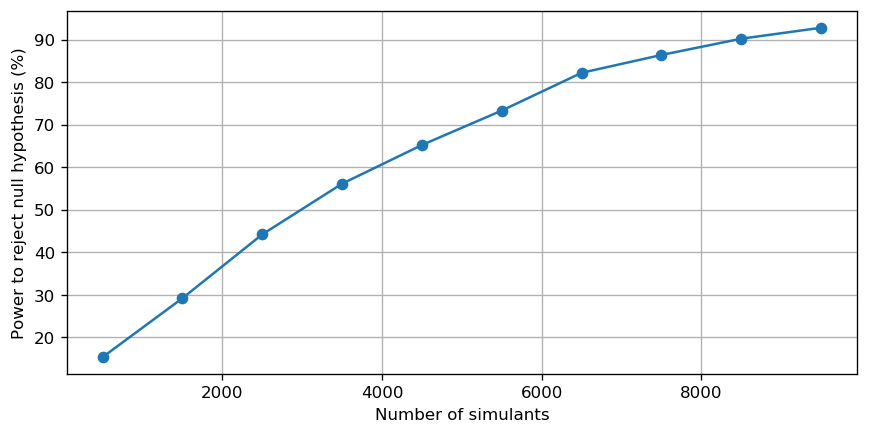

In [10]:
plt.figure(figsize=(8.5, 4), dpi=120)
(100*results).plot(marker='o')
plt.xlabel('Number of simulants')
plt.ylabel('Power to reject null hypothesis (%)')
plt.grid();

# How do the sample sizes compare to what I need?

In [11]:
rows = (data['df'].test_required == 1)
t = data['df'][rows]
t.date.map(pd.Timestamp).dt.week.value_counts().sort_index()

37    6366
38    7117
39    6840
40    6944
41    7449
42    5836
Name: date, dtype: int64

In [12]:
# I need this many weeks of data for 80% power
7_000 / 7_000

1.0